In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler                           
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, 
                             plot_confusion_matrix, 
                             accuracy_score, 
                             auc,
                             precision_recall_curve,
                             roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as sps

rand_state = 9789#9789#555#115

# Data overview

In [2]:
main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
PassengerID = test_df['PassengerId']
Survived = main_df['Survived']

In [3]:
main_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Feature engineering

In [5]:
def make_title(df):
    re_title_template = '([A-Za-z]+)\.'
    df['Title'] = df.Name.apply(lambda x: re.search(re_title_template, x).group(1))

In [6]:
make_title(main_df)
make_title(test_df)

In [7]:
main_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Lady          1
Capt          1
Sir           1
Jonkheer      1
Countess      1
Don           1
Mme           1
Name: Title, dtype: int64

In [8]:
def replace_title_name(x):
    title = x['Title']
    man_mr_titles = ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']
    woman_mrs_titles = ['Countess', 'Mme','Dona']
    woman_miss_titles = ['Mlle', 'Ms','Lady']
    if title in man_mr_titles:
        return 'Mr'
    elif title in woman_mrs_titles:
        return 'Mrs'
    elif title in woman_miss_titles:
        return 'Miss'
    elif title =='Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [9]:
main_df['Title'] = main_df.apply(replace_title_name, axis = 1)
test_df['Title'] = test_df.apply(replace_title_name, axis = 1)

In [10]:
main_df.Title.value_counts()

Mr        531
Miss      186
Mrs       134
Master     40
Name: Title, dtype: int64

In [11]:
test_df.Title.value_counts()

Mr        244
Miss       79
Mrs        74
Master     21
Name: Title, dtype: int64

In [12]:
def make_features(df):
    children_with_nanny = (df['Age']<18) & (df['Parch']==0)
    df['Family_Size'] = df['SibSp'] + df['Parch']
    # children without parents travell with nanny
    df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
    # family size and the person himself
    df['Fare_Per_Person'] = df['Fare'] / (df['Family_Size'] + 1)

In [13]:
make_features(main_df)
make_features(test_df)

In [14]:
def drop_unecessary_columns(df):
    columns_to_drop = ['PassengerId', 'Ticket','Name', 'Cabin','Fare', 'SibSp', 'Parch'] # 'SibSp', 'Parch',, 'Embarked' maybe too
    if 'Survived' in df.columns:
        columns_to_drop.append('Survived')
    df.drop(columns = columns_to_drop, inplace = True)

drop_unecessary_columns(main_df)
drop_unecessary_columns(test_df)

# Train Test Split

In [15]:
def custom_train_test_split(data, target_data):
    train_data, valid_data, train_value, valid_value  = train_test_split(data, target_data, test_size = 0.2, 
                                                                         random_state = rand_state, shuffle = True, stratify = target_data)
    return train_data, valid_data, train_value, valid_value

In [16]:
train_data, valid_data, train_value, valid_value  = custom_train_test_split(main_df, Survived)

# Remove nans

I needed first to remove nans to add some new features which depend on features with a lot of nans

In [17]:
def get_rid_of_nans(df):
    df['Age'] = df.groupby(['Sex','Title'])['Age'].transform(
    lambda grp: grp.fillna(np.mean(grp)))
#     df['Fare'] = df.groupby(['Sex','Title'])['Fare'].transform(
#     lambda grp: grp.fillna(np.mean(grp)))
    df['Fare_Per_Person'] = df.groupby(['Sex','Title'])['Fare_Per_Person'].transform(
    lambda grp: grp.fillna(np.mean(grp)))
    df['Embarked'].fillna(value = df['Embarked'].mode()[0], inplace = True)
    #df['Cabin'].fillna(value = 'NoCabin', inplace = True)
    re_cabin_template = "[A-Za-z]+"
    #df['Cabin'] = df['Cabin'].apply(lambda x: re.search(re_cabin_template, x).group(0))

get_rid_of_nans(train_data)
get_rid_of_nans(valid_data)
get_rid_of_nans(test_df)

In [18]:
train_data.isna().sum()

Pclass             0
Sex                0
Age                0
Embarked           0
Title              0
Family_Size        0
Fare_Per_Person    0
dtype: int64

# Feature engineering part II

In [19]:
def add_new_features(df: pd.DataFrame) -> None:
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['is_child'] = df['Age'].apply(lambda x: 1 if x < 18 else 0)
    df['is_adult_man'] = df.apply(lambda x: 1 if x['Sex']=='male' and x['Age']>=18 else 0, axis=1)
    df['is_alone'] = df['Family_Size'].apply(lambda x: 1 if x == 0 else 0)
    
add_new_features(train_data)
add_new_features(valid_data)
add_new_features(test_df)

## Labelling categorical features

In [20]:
def encoding_columns(df):
#     LE = LabelEncoder()
#     for feature in df.select_dtypes(include = ['object']):
#         df[feature] = LE.fit_transform(df[feature])
    df['Sex'] = df['Sex'].apply(lambda x: 1 if x=='male' else 0)
    df['Sex'] = df['Sex'].astype('int32')
    df = pd.get_dummies(df)
    return df

train_data = encoding_columns(train_data)
valid_data = encoding_columns(valid_data)
test_df = encoding_columns(test_df)

# Remove outliers

<AxesSubplot:xlabel='Survived', ylabel='Age'>

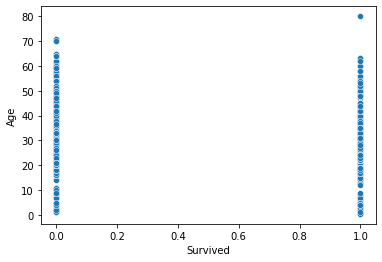

In [21]:
sns.scatterplot(train_value, train_data['Age'])

In [22]:
outl_age = train_data['Age']>76
train_data = train_data[~outl_age]
train_value = train_value[~outl_age]

<AxesSubplot:xlabel='Survived', ylabel='Fare_Per_Person'>

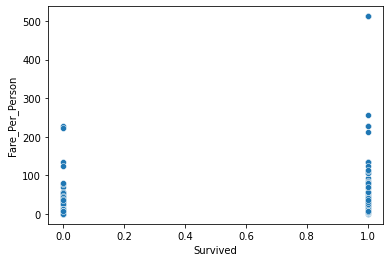

In [23]:
sns.scatterplot(train_value, train_data['Fare_Per_Person'])

In [24]:
outl_fare_per_person = train_data['Fare_Per_Person']>300
train_data = train_data[~outl_fare_per_person]
train_value = train_value[~outl_fare_per_person]

<AxesSubplot:xlabel='Survived', ylabel='Age*Class'>

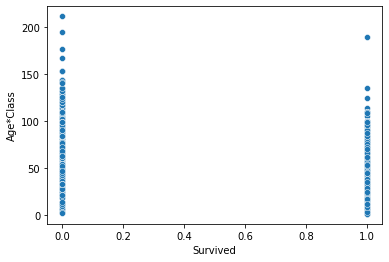

In [25]:
sns.scatterplot(train_value, train_data['Age*Class'])

In [26]:
age_class_outl = train_data['Age*Class']>160
train_data = train_data[~age_class_outl]
train_value = train_value[~age_class_outl]

# Some experiments before training in order to find out  which parameters are approximately the best

In [27]:
param_grid = {
    #"max_depth": [10, 11, 12]
    'max_samples': [100, 500, 600, None]
    #'random_state': [555, 777, 115, 9789, 543, 999, 1000, 2022]
    #"max_features": [4,5]
    #"min_samples_split": [6, 10],
    #"min_samples_leaf": [3, 5]
}

rf_cl = RandomForestClassifier(random_state=rand_state, 
                               n_estimators = 1500, 
                               max_features = 4,
                               max_depth = 10,
                               max_samples=100,
                               class_weight='balanced',
                              criterion='entropy')

rf_cl_tuned = GridSearchCV(estimator=rf_cl,
                            scoring='accuracy',
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-5,
                            verbose=2)

In [28]:
main_df_target = pd.concat((train_value, valid_value))
main_df_data = pd.concat((train_data, valid_data))

In [29]:
# rf_cl_tuned.fit(main_df_data, main_df_target)
# print(rf_cl_tuned.best_estimator_)
# print(rf_cl_tuned.best_score_)

# Scaling features

In [30]:
float_features = ['Age', 'Fare_Per_Person', 'Age*Class']#, 'Fare'] #,'
scaler = StandardScaler()
train_data[float_features] = scaler.fit_transform(train_data[float_features])
valid_data[float_features] = scaler.transform(valid_data[float_features])
test_df[float_features] = scaler.transform(test_df[float_features])

# RandomForest

In [51]:
def get_random_forest_model() -> object:
#     RFC = RandomForestClassifier(max_depth=5, max_features=5, 
#                                  min_samples_split=10, n_estimators=1000, 
#                                  random_state=rand_state, 
#                                  min_samples_leaf=5, criterion='entropy')
     RFC = RandomForestClassifier(max_depth=10,
                                 max_samples=100,
                       n_estimators=1500, 
                       max_features=4, 
                       class_weight='balanced',
                       random_state=rand_state, 
                       criterion='entropy')
#      RFC = RandomForestClassifier(max_depth=12,
#                                  max_samples=200,
#                        n_estimators=1500, 
#                        max_features=5, 
#                        #class_weight='balanced',
#                        random_state=rand_state, 
#                        criterion='entropy')
     return RFC

In [52]:
RFC = get_random_forest_model()
scores = cross_val_score(RFC, main_df_data, main_df_target, scoring="accuracy", cv = 5)
print(scores)
print(scores.mean())

[0.84745763 0.84180791 0.88135593 0.82386364 0.84659091]
0.8482152028762198


In [53]:
RFC = get_random_forest_model()
RFC.fit(train_data, train_value)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=4, max_samples=100,
                       n_estimators=1500, random_state=9789)

# Logitstic Regression

In [54]:
def get_logistic_regression() -> object:
    LRC = LogisticRegression(tol=1e-6, 
                             max_iter = 10000, 
                             penalty='none',
                             #C=0.5,
                             solver='lbfgs')#, class_weight='balanced')
    return LRC



In [55]:
# LRC = get_logistic_regression()
# scores = cross_val_score(LRC, main_df_data, main_df_target, 
#                          scoring="accuracy", cv = 5)
# print(scores)
# print(scores.mean())

In [56]:
LRC = get_logistic_regression()
LRC.fit(train_data, train_value)

LogisticRegression(max_iter=10000, penalty='none', tol=1e-06)

# PostHoc Analysis

In [57]:
def get_feature_importancy(ml_model):
    try:
        feature_importancy = ml_model.best_estimator_.feature_importances_
    except:
        feature_importancy = ml_model.feature_importances_
    return feature_importancy

In [58]:
def get_ml_params(ml_model):
    try:
        ml_params = ml_model.best_estimator_.get_params()
    except:
        ml_params = ml_model.get_params()
    return ml_params

In [59]:
def get_feature_importance_df(train_data, ml_model):
    feature_importancy = get_feature_importancy(ml_model)
    feature_imp_df = pd.DataFrame({'Feature': train_data.columns , 'Importance': feature_importancy })
    feature_imp_df = feature_imp_df.sort_values('Importance', ascending = False)
    return feature_imp_df

In [60]:
def make_metrics_report(y_test, y_pred, probs_predicted):
    precision, recall, thresholds = precision_recall_curve(y_test, probs_predicted)
    print(classification_report(y_test,y_pred))
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("ROC-AUC score: {}".format(roc_auc_score(y_test, probs_predicted)))
    print("PR-AUC score: {}".format(auc(recall, precision)))

In [61]:
def make_feature_importance_report(df, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    print(df)
    sns.barplot(x = df['Importance'], y = df['Feature'] )

In [62]:
def make_post_hoc_report(ml_model, valid_data, valid_value, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    ml_params = get_ml_params(ml_model)
    print("ML_model parameters: \n\n {} \n".format(ml_params))
    plot_confusion_matrix(ml_model, valid_data, valid_value)
    value_predicted = ml_model.predict(valid_data)
    probs_predicted = ml_model.predict_proba(valid_data)[:, 1]
    make_metrics_report(valid_value, value_predicted, probs_predicted)

In [63]:
feature_imp_df_rfc = get_feature_importance_df(train_data, RFC)

ML model name: RandomForestClassifier 

ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': None, 'max_samples': 100, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': None, 'oob_score': False, 'random_state': 9789, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       110
           1       0.88      0.67      0.76        69

    accuracy                           0.84       179
   macro avg       0.85      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179

Accuracy score: 0.8379888268156425
ROC-AUC score: 0.8515151515151516
PR-AUC score: 0.8460589458232671


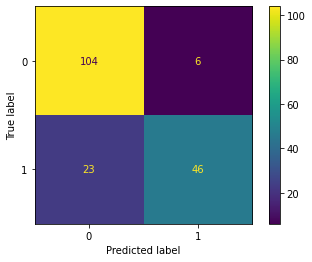

In [64]:
make_post_hoc_report(RFC, valid_data, valid_value, 'RandomForestClassifier')

ML model name: LogisticRegression 

ML_model parameters: 

 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 1e-06, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179

Accuracy score: 0.8156424581005587
ROC-AUC score: 0.8648221343873518
PR-AUC score: 0.8418973972811302


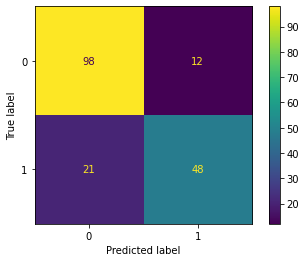

In [65]:
make_post_hoc_report(LRC, valid_data, valid_value, 'LogisticRegression')

ML model name: RandomForestClassifier 

            Feature  Importance
4   Fare_Per_Person    0.197719
5         Age*Class    0.162059
2               Age    0.136383
14         Title_Mr    0.091093
1               Sex    0.076494
7      is_adult_man    0.074944
3       Family_Size    0.065919
0            Pclass    0.064184
11       Embarked_S    0.023986
15        Title_Mrs    0.021380
13       Title_Miss    0.020906
9        Embarked_C    0.020901
8          is_alone    0.020127
10       Embarked_Q    0.011800
6          is_child    0.007670
12     Title_Master    0.004434


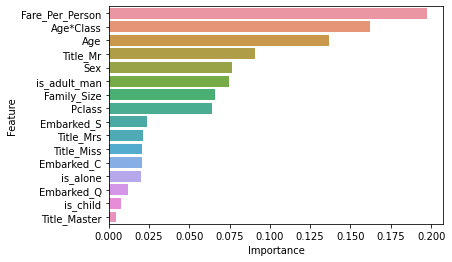

In [66]:
make_feature_importance_report(feature_imp_df_rfc, "RandomForestClassifier")

In [67]:
def get_best_acc(model, valid_data, valid_value) -> float:
    predict_probs = model.predict_proba(valid_data)[:,1]
    n_points = 50
    linsp = np.linspace(0.2, 0.8, n_points)
    accs = []
    max_acc = 0
    max_acc_thr = 0
    for thresh  in linsp:
        predictions = [int(prob >= thresh) for prob in predict_probs]
        acc = accuracy_score(valid_value, predictions)
        if acc >= max_acc:
            max_acc = acc
            max_acc_thr = thresh
        accs.append(acc)
        #print("thresh: {} acc: {}".format(thresh, acc))
    print("max acc: {} threshold: {}".format(max_acc, max_acc_thr))
    plt.plot(linsp, accs)
    return max_acc_thr
    

max acc: 0.8435754189944135 threshold: 0.48163265306122455


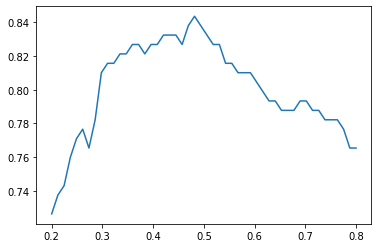

In [68]:
rfc_thr = get_best_acc(RFC, valid_data, valid_value)

max acc: 0.8268156424581006 threshold: 0.37142857142857144


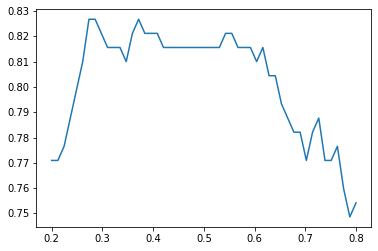

In [69]:
lrc_thr = get_best_acc(LRC, valid_data, valid_value)

# Write results to the CSV submission files

In [70]:
def make_csv_sub(df, PassengerID, ml_model, filename, threshold: float=0.5):
    test_predictions_probs = ml_model.predict_proba(df)[:,1]
    test_predictions = [int(prob >= threshold) for prob in test_predictions_probs]
    submit_df = pd.DataFrame({"PassengerID": PassengerID, "Survived": test_predictions})
    submit_df.to_csv(filename, index = False)
    
default_thr = 0.5
make_csv_sub(test_df, PassengerID, RFC, 'submission_rfc.csv', rfc_thr)
make_csv_sub(test_df, PassengerID, LRC, 'submission_lrc.csv', default_thr)